In [1]:
# In[1]:
!pip install keras tensorflow scikit-learn numpy

In [1]:

# In[1]:
import pandas as pd

# Load the training and testing data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [2]:
# Select the features to be used for the autoencoder
#selected_features = [1, 8, 12, 14, 79, 15, 18, 25, 28, 32, 33, 37, 39, 44, 46, 55, 56]
selected_features = [
    'Dst Port', 'Fwd Packet Length Max', 'Bwd Packet Length Max',
    'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow IAT Mean',
    'Fwd IAT Std', 'Bwd IAT Mean', 'Fwd PSH Flags', 'Bwd PSH Flags',
    'Fwd RST Flags', 'Fwd Header Length', 'Packet Length Max',
    'Packet Length Std', 'Fwd Segment Size Avg', 'Bwd Segment Size Avg',
    'ICMP Type'
]
X_train = train_data.loc[:, selected_features]
y_train = train_data['Label']  # Assuming the last column is 'Label'
X_test = test_data.loc[:, selected_features]
y_test = test_data['Label']    # Assuming the last column is 'Label'


In [3]:
# In[5]:
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping

def create_autoencoder(input_dim):
    # Define the sizes of the encoded representations
    encoding_dim_1 = int(input_dim / 2)
    encoding_dim_2 = int(encoding_dim_1 / 2)
    bottleneck_dim = int(encoding_dim_2 / 2)

    # Define input layer
    input_layer = Input(shape=(input_dim,))

    # Define encoding layers
    encoded_1 = Dense(encoding_dim_1, activation='relu')(input_layer)
    encoded_1 = Dropout(0.3)(encoded_1)  # Dropout layer
    encoded_2 = Dense(encoding_dim_2, activation='relu')(encoded_1)
    encoded_2 = Dropout(0.3)(encoded_2)  # Dropout layer
    bottleneck = Dense(bottleneck_dim, activation='relu')(encoded_2)

    # Define decoding layers
    decoded_1 = Dense(encoding_dim_2, activation='relu')(bottleneck)
    decoded_1 = Dropout(0.3)(decoded_1)  # Dropout layer
    decoded_2 = Dense(encoding_dim_1, activation='relu')(decoded_1)
    decoded_2 = Dropout(0.3)(decoded_2)  # Dropout layer
    output_layer = Dense(input_dim, activation='sigmoid')(decoded_2)

    # Combine the layers to create the autoencoder model
    autoencoder = Model(input_layer, output_layer)

    return autoencoder

In [4]:
# In[6]:
# 1. Feature Scaling:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Model Creation and Compilation:
input_dim = X_train_scaled.shape[1]
autoencoder = create_autoencoder(input_dim)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# 3. Early Stopping:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 4. Training the Model:
autoencoder.fit(X_train_scaled, X_train_scaled,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test_scaled, X_test_scaled),
                callbacks=[early_stopping])

autoencoder.save('autoencoder_model1_ARP.h5')

2023-11-06 22:35:26.929957: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2023-11-06 22:35:26.929986: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-11-06 22:35:26.929994: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-11-06 22:35:26.930026: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-06 22:35:26.930041: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2023-11-06 22:35:27.458929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2023-11-06 22:35:27.500535: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


3229/3229 [==============================] - 27s 8ms/step - loss: 0.8897 - val_loss: 0.8491
Epoch 2/50
3229/3229 [==============================] - 26s 8ms/step - loss: 0.8285 - val_loss: 0.8100
Epoch 3/50
3229/3229 [==============================] - 26s 8ms/step - loss: 0.8947 - val_loss: 0.9115
Epoch 4/50
3229/3229 [==============================] - 26s 8ms/step - loss: 0.9290 - val_loss: 0.9453
Epoch 5/50
3229/3229 [==============================] - 27s 8ms/step - loss: 0.9345 - val_loss: 0.9326
Epoch 6/50
3229/3229 [==============================] - 27s 8ms/step - loss: 0.9353 - val_loss: 0.9396
Epoch 7/50
3229/3229 [==============================] - 27s 8ms/step - loss: 0.9387 - val_loss: 0.9334


/Users/christinastodt/anaconda3/envs/AnomalyTest/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [5]:
autoencoder.save('autoencoder_model1_ARP.h5')

In [6]:
# In[7]:
import numpy as np

# Predict the test set
predictions = autoencoder.predict(X_test_scaled)

# Calculate mean squared error between predictions and actual values
mse = np.mean(np.power(X_test_scaled - predictions, 2), axis=1)


11070/11070 [==============================] - 15s 1ms/step


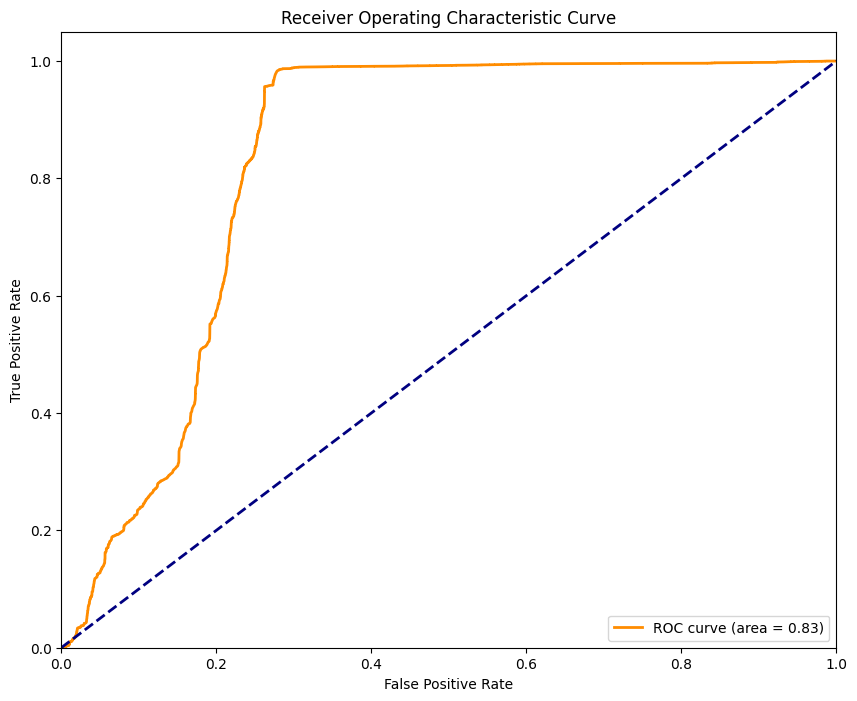

In [7]:
# In[8]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, mse)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

In [8]:
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

# Ensure you use the scaled test data for making predictions
X_test_predictions = autoencoder.predict(X_test_scaled)

# Calculating the mean squared error (reconstruction error) between the original scaled data and their reconstructions
mse = np.mean(np.power(X_test_scaled - X_test_predictions, 2), axis=1)

# Print the mean squared errors
print("Reconstruction error (MSE) for each sample:")
print(mse)
general_mse = np.mean(mse)

# Choose a threshold value for which F1 score is maximized
thresholds = np.linspace(0.1, 10, 200)  # Adjust the range and granularity as needed
f1_scores = [f1_score(y_test, mse > threshold) for threshold in thresholds]
optimal_threshold = thresholds[np.argmax(f1_scores)]

# Predicting anomalies using the optimal threshold
y_pred = (mse > optimal_threshold).astype(int)

# Calculating F1 score and accuracy based on the reconstruction error
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"Optimal Threshold: {optimal_threshold}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print(f"General MSE: {general_mse}")




11070/11070 [==============================] - 15s 1ms/step
Reconstruction error (MSE) for each sample:
[2.67385872 0.13162605 0.10880438 ... 0.72839615 0.15520161 1.82386887]
Optimal Threshold: 0.19949748743718593
F1 Score: 0.6151725318134499
Accuracy: 0.7714678508012952
General MSE: 0.8099591333781285
